# Problem Statement:

Persistency of drug as per the physician prescription

# ML Problem: Classification

# Target Variable: Persistency_Flag

Feature Description:

Unique Row Id	
Patient ID	
Persistency_Flag	
Demographics:
 - Age	
 - Race	
 - Region
 - Ethnicity	
 - Gender	
 - IDN Indicator	---Flag indicating patients mapped to IDN

Provider Attributes	

 - NTM - Physician Specialty -----	Specialty of the HCP that prescribed the NTM Rx
 - NTM - T-Score 	
 - T Score       ------        at the time of the NTM Rx (within 2 years prior from rxdate)
 - Change in T Score 	------ before starting with any therapy and after receiving therapy  
                         (Worsened, Remained Same, Improved, Unknown)
 - NTM Risk Segment	---- at the time of the NTM Rx (within 2 years days prior from rxdate)
 - Change in Risk Segment	before starting with any therapy and after receiving therapy
                         (Worsened, Remained Same, Improved, Unknown)
 - NTM Multiple Risk Factors -----	if  patient falls under multiple risk category (having more than 1 risk) at the time of the NTM Rx (within 365 days prior from rxdate)

Clinical Factors:

 - NTM - Dexa Scan Frequency	----Number of DEXA scans taken prior to the first NTM Rx date (within 365 days prior from rxdate)
 - NTM - Dexa Scan Recency	 ----   the presence of Dexa Scan before the NTM Rx (within 2 years prior from rxdate or between their first Rx and Switched Rx; whichever is smaller and applicable)
 - Dexa During Therapy	  -----      if the patient had a Dexa Scan during their first continuous therapy
 - NTM - Fragility Fracture Recency	if the patient had a recent fragility fracture (within 365 days prior from rxdate)
 - Fragility Fracture During Therapy ----	if the patient had fragility fracture  during their first continuous therapy
 - NTM - Glucocorticoid Recency	  usage of Glucocorticoids (>=7.5mg strength) in the one year look-back from the first NTM Rx
 - Glucocorticoid Usage During Therapy	---if the patient had a Glucocorticoid usage during the first continuous therapy
 - NTM - Injectable Experience	-----any injectable drug usage in the recent 12 months before the NTM OP Rx
 - NTM - Risk Factors	------- Risk Factors that the patient is falling into. 
                                for chronic Risk Factors complete lookback to be applied 
                                for non-chronic Risk Factors, one year lookback from the date of first OP Rx 
 
 
Disease/Treatment Factor

 - NTM - Comorbidity 	-----Comorbidities are divided into two main categories based on the ICD codes
                               Acute 
                               Chronic --- For chronic disease we are taking complete look back from the first Rx date of NTM therapy and for acute diseases, time period  before the NTM OP Rx with one year lookback has been applied
                              
 - NTM - Concomitancy	Concomitant drugs recorded prior to starting with a therapy(within 365 days prior from first rxdate)
 - Adherence	Adherence for the therapies

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn import preprocessing
import copy
from sklearn.model_selection import train_test_split

In [25]:
!/usr/bin/env python -W ignore::DeprecationWarning

The system cannot find the path specified.


In [26]:
import warnings
warnings.filterwarnings("ignore")

# NAN values

In [56]:
na_values = ['Unknown','Other/Unknown'] # add all values that should be converted to np.nan
ds = pd.read_excel('C:\\Users\\user\\Downloads\\git_v3\\HealthCare_project\\Healthcare_dataset.xlsx', 
                   'Dataset', index_col=None,na_values= na_values, keep_default_na = False)


In [57]:
def chec_nan_values(dataset):
    found = False
    list_column_nan = []
    for column in ds.columns:
        if ds[column].isnull().sum() != 0:
            found = True
            print('Column',column, 'has', ds[column].isnull().sum(),' null values')
            list_column_nan.append(column)
    if found  == False:
        print('The dataset does not contain empty values')
    return list_column_nan

In [58]:
list_column_nan = chec_nan_values(ds)

Column Race has 97  null values
Column Ethnicity has 91  null values
Column Region has 60  null values
Column Ntm_Speciality has 310  null values
Column Risk_Segment_During_Rx has 1497  null values
Column Tscore_Bucket_During_Rx has 1497  null values
Column Change_T_Score has 1497  null values
Column Change_Risk_Segment has 2229  null values


See plots how many NaN points are, related to other column categories.
![image info](./change_risk_Segment.png)
![image info](./change_t_score.png)
![image info](./ethnicity.png)
![image info](./ntm_specialty.png)
![image info](./risk_segment_during_rx.png)
![image info](./tscore_bucket_during_rx.png)

# Predicting unknown values

Reading with unknown values original plot

In [59]:
ds = ds.replace(['N','Y'],[0,1])

In [60]:
list_columns_need_labelling = ['Persistency_Flag', 'Gender', 'Race','Ethnicity','Region','Age_Bucket','Ntm_Speciality','Ntm_Specialist_Flag','Ntm_Speciality_Bucket','Risk_Segment_Prior_Ntm', 'Tscore_Bucket_Prior_Ntm', 'Risk_Segment_During_Rx', 'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment', 'Adherent_Flag']

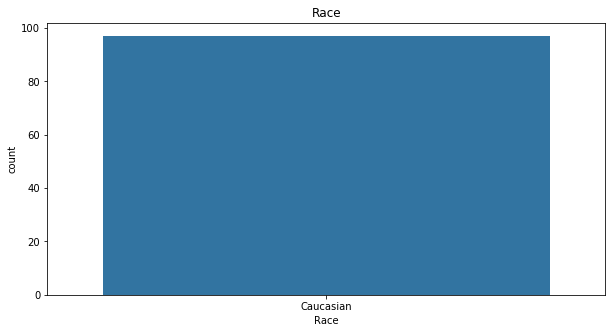

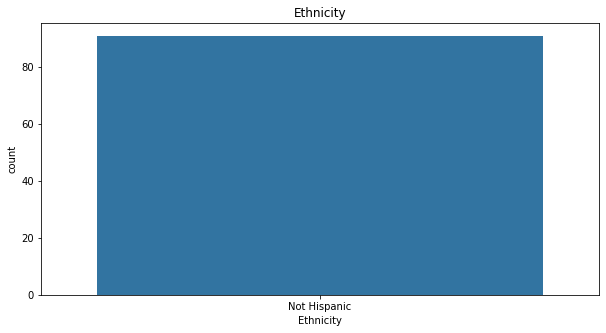

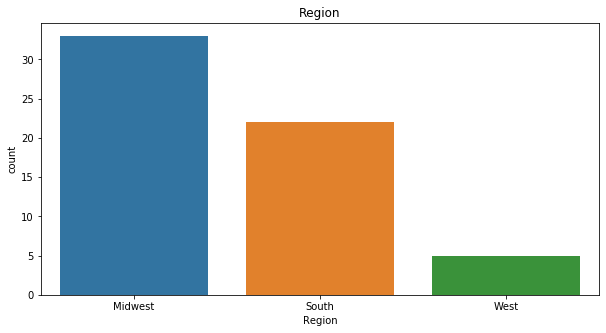

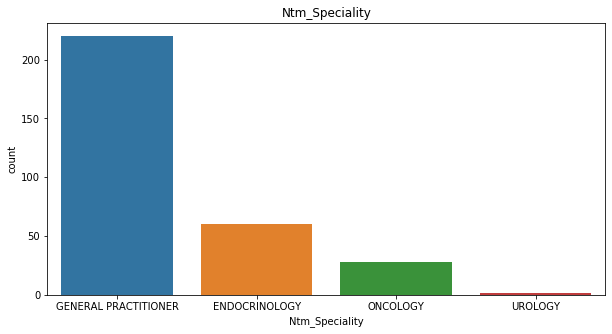

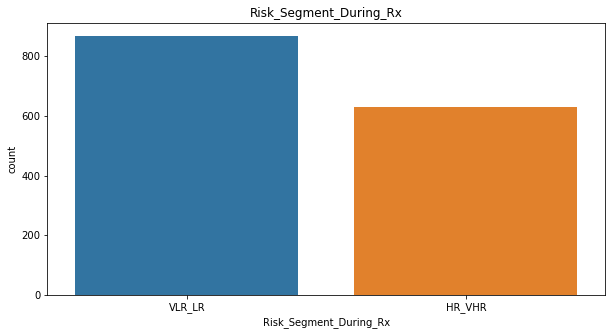

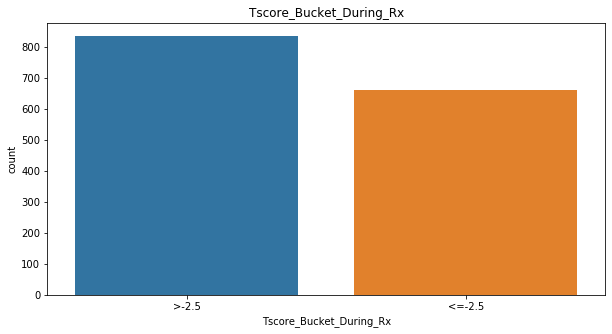

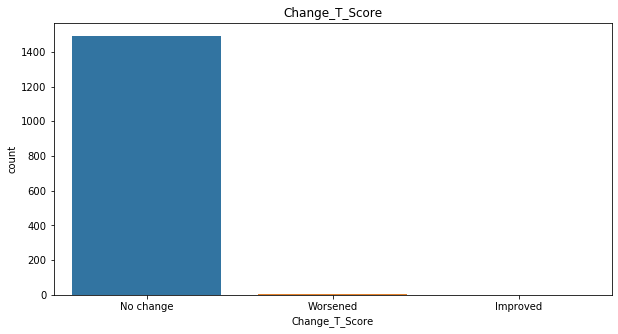

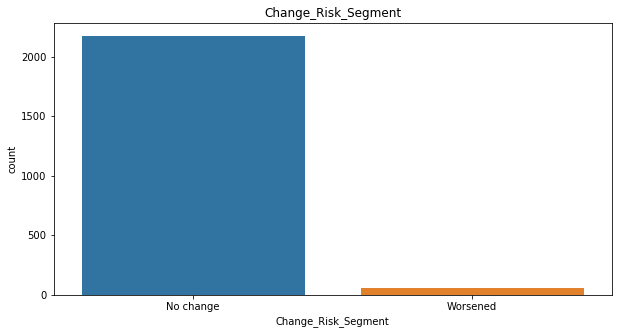

In [61]:
lr  = LogisticRegression(solver='newton-cg', random_state=0,class_weight=None)

for column_predict in list_column_nan:
    ds_copy = ds.copy()
    dict_labels = {}
    list_column_to_be_deleted = [i for i in list_column_nan if i!= column_predict ]
    ds_copy.drop( list_column_to_be_deleted, axis=1, inplace=True)
        
    X_train = ds_copy[ds_copy[column_predict].notnull()]    
    X_train.drop('Ptid', axis=1, inplace=True)
    X_test = ds_copy[pd.isnull(ds_copy[column_predict])]
    new_predicted_df = pd.DataFrame (X_test['Ptid'])
    X_test.drop('Ptid', axis=1, inplace=True)
    
    list_column_label = [x for x in list_columns_need_labelling if x not in list_column_to_be_deleted ]
    
    le = preprocessing.LabelEncoder()

    for column in list_column_label:
        new_column_name = "{}_labels".format(column)
        if column != column_predict:
            X_train[new_column_name] = le.fit_transform(X_train[[column]])
            X_test[new_column_name] = le.fit_transform(X_test[[column]])
        else:
            y_train = pd.DataFrame(le.fit_transform(X_train[[column]]))
        
            for k in range(len(le.classes_)):
                dict_labels[le.transform(le.classes_)[k]] =  le.classes_[k]

            
    X_train = X_train.select_dtypes(include= np.number)
    X_test =  X_test.select_dtypes(include= np.number)
        
    lr.fit(X_train, y_train)
    predictions = lr.predict(X_test)
    
    new_predicted_df['{}'.format(column_predict)] = [dict_labels[j] for j in predictions]
    new_predicted_df.to_csv("predicted_{}_df.csv".format(column_predict), index = None)
    
   
    plt.figure(figsize=(10, 5))
    sns.countplot(new_predicted_df[column_predict])
    plt.title(column_predict)


# Merge predictions dataframe

In [62]:
for column_predict in list_column_nan:
    df = pd.read_csv("predicted_{}_df.csv".format(column_predict))
    ds.loc[pd.isnull(ds[column_predict]),[column_predict]]= df[column_predict].values

In [63]:
ds.shape

(3424, 69)

In [64]:
chec_nan_values(ds)

The dataset does not contain empty values


[]

In [65]:
columns_risks = []
columns_true = []
columns_false = []
for column in ds.columns: 
    if "Risk" in column and len(ds.value_counts(column).index) ==2 and ds.value_counts(column).index[0] == 0:
        columns_risks.append(column)
        columns_true.append(ds.value_counts(column)[1])
        columns_false.append(ds.value_counts(column)[0])
    elif  "Risk" in column: 
        print(ds.value_counts(column))

table = pd.DataFrame({'columns':columns_risks ,'True': columns_true, "False": columns_false})    
table

Risk_Segment_Prior_Ntm
VLR_LR    1931
HR_VHR    1493
dtype: int64
Risk_Segment_During_Rx
VLR_LR    1830
HR_VHR    1594
dtype: int64
Change_Risk_Segment
No change    3224
Worsened      178
Improved       22
dtype: int64
Count_Of_Risks
1    1242
0     970
2     781
3     317
4      91
5      15
6       6
7       2
dtype: int64


,columns,True,False
0,Risk_Type_1_Insulin_Dependent_Diabetes,139,3285
1,Risk_Osteogenesis_Imperfecta,3,3421
2,Risk_Rheumatoid_Arthritis,130,3294
3,Risk_Untreated_Chronic_Hyperthyroidism,2,3422
4,Risk_Untreated_Chronic_Hypogonadism,127,3297
5,Risk_Untreated_Early_Menopause,12,3412
6,Risk_Patient_Parent_Fractured_Their_Hip,256,3168
7,Risk_Smoking_Tobacco,644,2780
8,Risk_Chronic_Malnutrition_Or_Malabsorption,470,2954
9,Risk_Chronic_Liver_Disease,18,3406


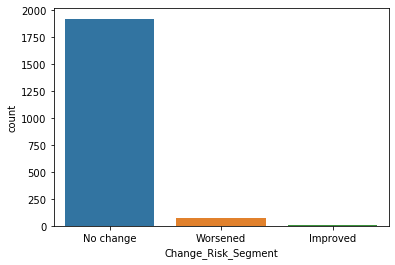

In [66]:
sns.countplot(cleaned_data['Change_Risk_Segment'])

## Outliers

# Delete uncesessary columns

In [38]:
len(ds.columns)

69

In [39]:
list_columns_deleted = ['Ptid', 'Gender','Risk_Type_1_Insulin_Dependent_Diabetes','Risk_Osteogenesis_Imperfecta','Risk_Rheumatoid_Arthritis','Risk_Untreated_Chronic_Hyperthyroidism','Risk_Untreated_Chronic_Hypogonadism','Risk_Untreated_Early_Menopause','Risk_Patient_Parent_Fractured_Their_Hip','Risk_Chronic_Liver_Disease','Risk_Low_Calcium_Intake','Risk_Poor_Health_Frailty','Risk_Excessive_Thinness','Risk_Hysterectomy_Oophorectomy','Risk_Estrogen_Deficiency','Risk_Immobilization','Risk_Recurring_Falls']


In [40]:
ds.drop(list_columns_deleted, axis=1, inplace=True)

In [41]:
len(ds.columns)

52

# Label categorical columns as numerical values

In [42]:
list_columns_need_labelling = ['Persistency_Flag', 'Race','Ethnicity','Region','Age_Bucket','Ntm_Speciality','Ntm_Specialist_Flag','Ntm_Speciality_Bucket','Risk_Segment_Prior_Ntm', 'Tscore_Bucket_Prior_Ntm', 'Tscore_Bucket_During_Rx', 'Change_T_Score', 'Change_Risk_Segment', 'Adherent_Flag']

In [43]:
from sklearn.preprocessing import OrdinalEncoder

ord_enc = OrdinalEncoder()

for column in list_columns_need_labelling:
    new_column_name = "{}_labels".format(column)
    ds[new_column_name] = ord_enc.fit_transform(ds[[column]])

In [44]:
len(ds.columns)

66

# Delete outliers

In [45]:
list_columns_contain_outliers = ['Race_labels','Ethnicity_labels','Region_labels', 'Ntm_Speciality_labels', 'Dexa_Freq_During_Rx', 'Adherent_Flag_labels']

In [46]:
ds.shape

(3424, 66)

In [47]:
for column in list_columns_contain_outliers:
    category_counts = ds.value_counts(column)
    values_category_counts = list(category_counts)                                          
    for element in range(len(values_category_counts)):
        if values_category_counts[element] < 100:
            ds.drop(ds.loc[ds[column]==category_counts.index[element]].index, inplace=True)

In [48]:
ds.shape

(2004, 66)

Save data including labeled columns but also original categories column with no Nan values and no outliers

Ready for EDA

In [106]:
ds.to_csv('cleaned_data.csv', index = False)

In [50]:
cleaned_data = pd.read_csv('cleaned_data.csv')

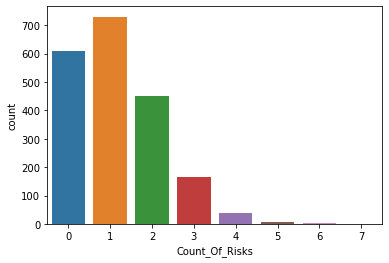

In [51]:
sns.countplot(cleaned_data['Count_Of_Risks'])

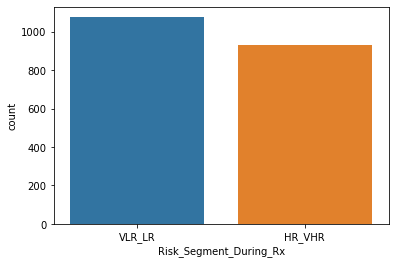

In [54]:
sns.countplot(cleaned_data['Risk_Segment_During_Rx'])

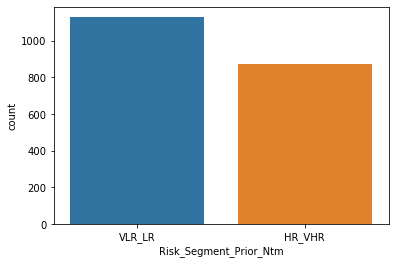

In [55]:
sns.countplot(cleaned_data['Risk_Segment_Prior_Ntm'])